# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```
## What is expected?

* Complete and run the code using `jupyter-lab`.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* If Jupyter complains issues during exporting, it is likely that [pandoc](https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry. Alternatively, use the Print function of your browser to export the PDF file.

* If Jupyter-lab does not work for you at the end, alternatively, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [1]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## Q1. Download and visualise the imaging dataset.

The dataset is a public brain imaging dataset from [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from the original 3D volumes (T1-Gd contrast enhanced imaging) and downsample the 2D images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset (cross-platform)
url = 'https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz?dl=1'
out_file = 'Task01_BrainTumour_2D.tar.gz'

if not os.path.exists(out_file):
    import urllib.request
    urllib.request.urlretrieve(url, out_file)

# Unzip the '.tar.gz' file to the current directory
if not os.path.exists('Task01_BrainTumour_2D'):
    datafile = tarfile.open(out_file)
    datafile.extractall()
    datafile.close()

print('Dataset is ready.')

/tmp/ipython-input-3648749530.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  datafile.extractall()


Dataset is ready.


## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

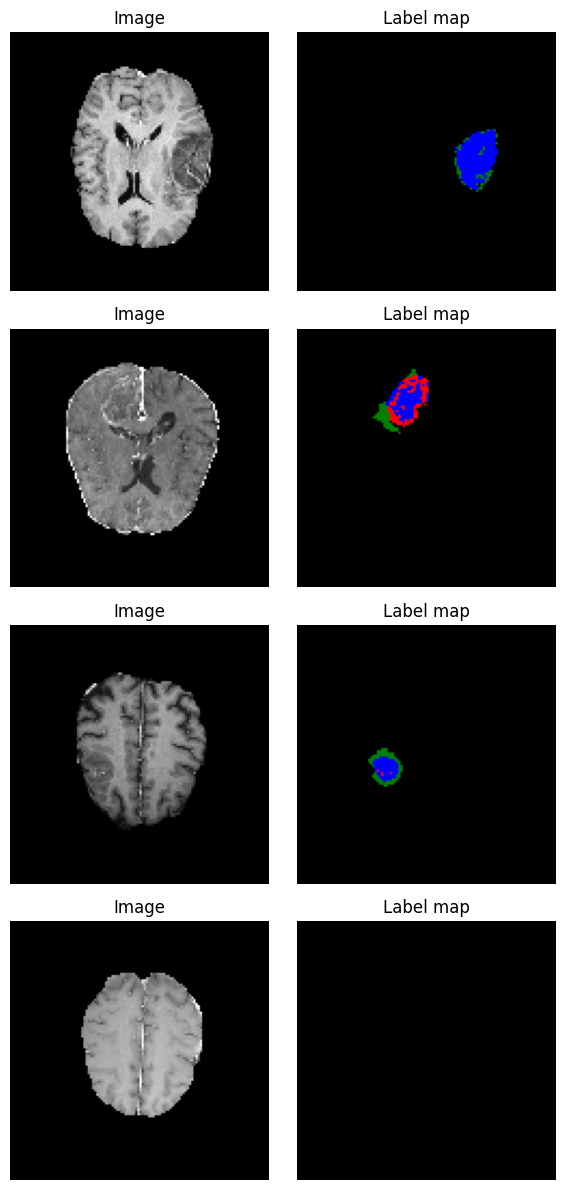

In [3]:
### Insert your code ###
# Load training images and labels
train_img_path = 'Task01_BrainTumour_2D/training_images'
train_label_path = 'Task01_BrainTumour_2D/training_labels'
image_names = sorted(os.listdir(train_img_path))

# Randomly select 4 images
indices = random.sample(range(len(image_names)), 4)

# Create 4x2 subplot: each row shows image and its label map
fig, axes = plt.subplots(4, 2, figsize=(6, 12))
seg_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

for i, idx in enumerate(indices):
    image = imageio.v2.imread(os.path.join(train_img_path, image_names[idx]))
    label = imageio.v2.imread(os.path.join(train_label_path, image_names[idx]))
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(label, cmap=seg_cmap, vmin=0, vmax=3)
    axes[i, 1].set_title('Label map')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()
### End of your code ###

## Q2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, to be used as training batches.

In [4]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.v2.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.v2.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        indices = [random.randint(0, len(self) - 1) for _ in range(batch_size)]
        for idx in indices:
            image, label = self[idx]
            # Add channel dimension for image: (H, W) -> (1, H, W)
            images.append(np.expand_dims(image, axis=0))
            labels.append(label)
        images = np.stack(images, axis=0).astype(np.float32)  # (N, 1, H, W)
        labels = np.stack(labels, axis=0).astype(np.int64)   # (N, H, W)
        ### End of your code ###
        return images, labels

## Q3. Build a U-net architecture.

Implement a U-net architecture for image segmentation. If you are not familiar with U-net, you can read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [5]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###
        # Up1: 128 -> 64, upsample and concat with conv3_skip (64)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        # Up2: 64 -> 32, upsample and concat with conv2_skip (32)
        self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv6 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        # Up3: 32 -> 16, upsample and concat with conv1_skip (16)
        self.upconv3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv7 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv_out = nn.Conv2d(16, output_channel, kernel_size=1)
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        x = self.upconv1(x)
        x = torch.cat([x, conv3_skip], dim=1)
        x = self.conv5(x)

        x = self.upconv2(x)
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.conv6(x)

        x = self.upconv3(x)
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.conv7(x)

        x = self.conv_out(x)
        ### End of your code ###
        return x

## Q4. Train the segmentation model.

In [6]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
# 设为 500 可快速验证，10000 为完整训练
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    if it % 100 == 0:
        print('Iter {0}: train loss = {1:.4f}'.format(it, loss.item()))
    ### End of your code ###

    # Evaluate
    if it % 1000 == 0:
        model.eval()
        # Disabling gradient calculation during inference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_images, test_labels = test_set.get_random_batch(eval_batch_size)
            test_images = torch.from_numpy(test_images).to(device, dtype=torch.float32)
            test_labels = torch.from_numpy(test_labels).to(device, dtype=torch.long)
            test_logits = model(test_images)
            test_loss = criterion(test_logits, test_labels)
            print('Iter {0}: test loss = {1:.4f}'.format(it, test_loss.item()))
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
# 训练结束时保存（当 num_iter < 5000 时）
torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(num_iter)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda
Iter 100: train loss = 0.4722
Iter 200: train loss = 0.1740
Iter 300: train loss = 0.0795
Iter 400: train loss = 0.0600
Iter 500: train loss = 0.0569
Iter 600: train loss = 0.0677
Iter 700: train loss = 0.0582
Iter 800: train loss = 0.0490
Iter 900: train loss = 0.0526
Iter 1000: train loss = 0.0493
Iter 1000: test loss = 0.0539
Iter 1100: train loss = 0.0325
Iter 1200: train loss = 0.0479
Iter 1300: train loss = 0.0361
Iter 1400: train loss = 0.0307
Iter 1500: train loss = 0.0315
Iter 1600: train loss = 0.0427
Iter 1700: train loss = 0.0333
Iter 1800: train loss = 0.0313
Iter 1900: train loss = 0.0332
Iter 2000: train loss = 0.0262
Iter 2000: test loss = 0.0228
Iter 2100: train loss = 0.0259
Iter 2200: train loss = 0.0321
Iter 2300: train loss = 0.0257
Iter 2400: train loss = 0.0226
Iter 2500: train loss = 0.0215
Iter 2600: train loss = 0.0229
Iter 2700: train loss = 0.0153
Iter 2800: train loss = 0.0288
Iter 2900: train loss = 0.0201
Iter 3000: train loss = 0.0263
Iter 3

## Q5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

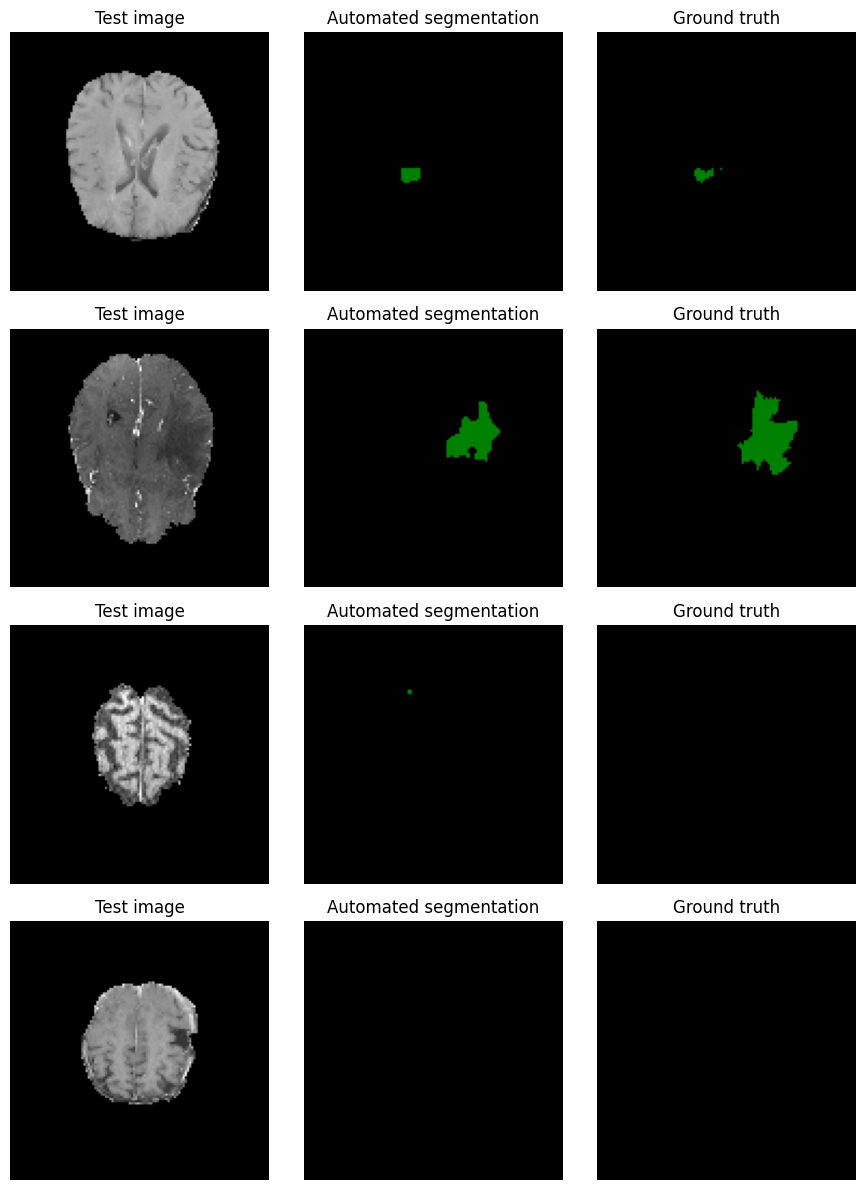

In [7]:
### Insert your code ###
# Load the trained model (use the last saved checkpoint)
model_files = [f for f in os.listdir(model_dir) if f.startswith('model_') and f.endswith('.pt')]
model_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
model_path = os.path.join(model_dir, model_files[-1]) if model_files else os.path.join(model_dir, 'model_10000.pt')
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    print('Warning: No saved model found. Run Q4 training first.')
model.eval()

# Get 4 random test images
test_indices = random.sample(range(len(test_set)), 4)
seg_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

fig, axes = plt.subplots(4, 3, figsize=(9, 12))

with torch.no_grad():
    for i, idx in enumerate(test_indices):
        image, label_gt = test_set[idx]
        # Prepare input: (1, 1, H, W)
        image_tensor = torch.from_numpy(np.expand_dims(np.expand_dims(image, 0), 0)).to(device, dtype=torch.float32)
        logits = model(image_tensor)
        pred = torch.argmax(logits, dim=1).cpu().numpy()[0]  # (H, W)

        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Test image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(pred, cmap=seg_cmap, vmin=0, vmax=3)
        axes[i, 1].set_title('Automated segmentation')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(label_gt, cmap=seg_cmap, vmin=0, vmax=3)
        axes[i, 2].set_title('Ground truth')
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## Q6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

**Discussion**

**1) Does your trained model work well?**

The trained U-Net model generally performs reasonably well on this brain tumour segmentation task. It can segment the major tumour regions (edema, non-enhancing tumour, enhancing tumour) from the background. However, performance varies across cases:

- It works better when tumour boundaries are clear.
- Small or diffuse tumour regions are harder to segment accurately.
- Class imbalance (background-dominant pixels) can reduce performance on less frequent tumour classes.

**2) How would you improve this model for real clinical deployment?**

- **Data:** use more diverse multi-centre datasets, include 3D volumes, and apply stronger augmentation.
- **Architecture:** move to 3D U-Net or attention-based variants for richer context.
- **Training:** use Dice-based losses (or CE + Dice), and add validation-driven early stopping.
- **Evaluation:** report clinically meaningful metrics (class-wise Dice, Hausdorff distance) and external validation.
- **Safety:** add uncertainty estimation, input quality checks, and reproducibility controls.